# Big Data Project 20211

In [1]:
from src.spark_helper import Spark
from configs import configs
from src.data_helper import Processor
from src.spark_mlib import SparkMLib
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
''' Initialize Spark and Processor '''
proc = Processor()
spark = Spark()
smlib = SparkMLib()

In [3]:
''' Connect to Spark '''
spark.connect(configs['spark'])

21/12/18 02:45:00 WARN Utils: Your hostname, NeiH resolves to a loopback address: 127.0.1.1; using 192.168.1.9 instead (on interface wlp3s0)
21/12/18 02:45:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/18 02:45:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/hienvq/anaconda3/envs/ds/lib/python3.9/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Spark Context Created


True

## Data Collection

In [4]:
''' Load data '''
data = pd.read_csv(configs['data-path'] + configs['data-file'])

In [5]:
''' preprocessing '''
data['review'] = data['review'].apply(lambda x: proc.finalpreprocess(x))
one_hot_labels = proc.one_hot_encode(data['sentiment'].unique())
data['label'] = data['sentiment'].apply(lambda x: one_hot_labels[x])

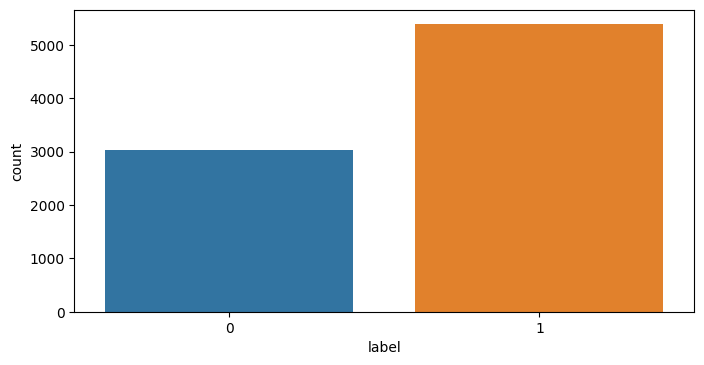

                                       review sentiment  label
0                           mainly pay bottle  positive      1
1  mislead advertisement conspicuous business  negative      0
2                                    water ok  negative      0
3                                  love water  positive      1
4                                      usable  positive      1


In [6]:

''' visualize data '''
plt.figure(figsize = (8,4), dpi = 100)
sns.countplot(data = data, x = 'label')
# plt.xticks(rotation = 90)
plt.show()
print(data.head())

In [7]:
''' Convert data to Spark DataFrame '''
data = spark.pandas_to_df(data)
train, test = data.randomSplit([0.8, 0.2], seed=12345)

In [8]:
''' Create model and pipeline '''
model, pramGrid = smlib.get_model('lr')
tokenizer = smlib.get_tokenizer('review', 'words')
pipeline = smlib.get_pipeline(model, tokenizer, pramGrid)

## Fit Model

In [9]:
model_pipeline = pipeline.fit(train)

21/12/18 02:45:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/18 02:45:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
21/12/18 02:45:31 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/18 02:45:31 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


## Evaluate Model

In [10]:
predictions = model_pipeline.transform(test)
# Select example rows to display.
predictions.select("review", "sentiment", "label", "prediction").show(20)
# Select (prediction, true label) and compute test error.
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

+--------------------+---------+-----+----------+
|              review|sentiment|label|prediction|
+--------------------+---------+-----+----------+
|  1 month fall apart| negative|    0|       1.0|
|5 10 235 lb shirt...| positive|    1|       1.0|
|              5 star| positive|    1|       1.0|
|able download goo...| negative|    0|       0.0|
|acer chrom notebo...| positive|    1|       1.0|
|    alienware m15 r4| positive|    1|       0.0|
|         almost love| negative|    0|       0.0|
|amazing quality a...| positive|    1|       1.0|
|awesome birthday ...| positive|    1|       1.0|
|awesome gift warr...| positive|    1|       1.0|
|awesome little la...| positive|    1|       1.0|
|          back black| negative|    0|       0.0|
|bad arm computer buy| negative|    0|       0.0|
|      bad experience| negative|    0|       0.0|
|      bad many level| negative|    0|       0.0|
|         bad quality| negative|    0|       0.0|
|bad shirt ever ow...| negative|    0|       0.0|


In [11]:
''' Close Spark '''
# spark.close()

' Close Spark '